In [2]:
import os
import csv
import cv2
import json
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score
import imageio as io
import matplotlib.pyplot as plt
import pandas as pd

2025-02-03 17:53:58.491887: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-03 17:53:58.784580: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-03 17:53:58.784696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-03 17:53:58.833657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 17:53:58.970211: I tensorflow/core/platform/cpu_feature_guar

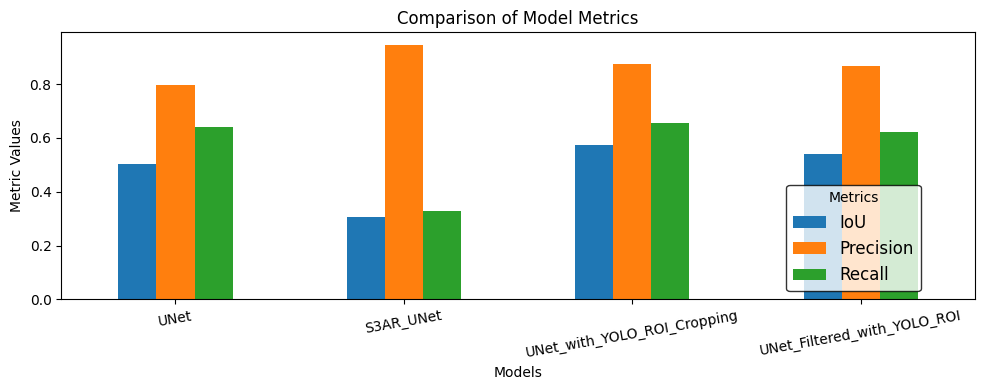

In [9]:
def calculate_dice(ground_truth_mask, predicted_mask):
    if np.sum(ground_truth_mask) == 0 and np.sum(predicted_mask) == 0:
        return 1.0
    intersection = np.logical_and(ground_truth_mask, predicted_mask)
    dice = 2 * np.sum(intersection) / (np.sum(ground_truth_mask) + np.sum(predicted_mask))
    return dice

def calculate_iou(mask1, mask2):
    if np.sum(mask1) == 0 and np.sum(mask2) == 0:
        return 1.0
    elif np.sum(mask1) == 0 or np.sum(mask2) == 0:
        return 0.0
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def save_metrics_to_csv(output_csv, results, overall_metrics):
    with open(output_csv, "w", newline="") as csvfile:
        fieldnames = ["Patient", "IoU", "Dice", "Precision", "Recall", "F1"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for patient, metrics in results.items():
            row = {"Patient": patient, **metrics}
            writer.writerow(row)

        writer.writerow({"Patient": "Overall", **overall_metrics})

def evaluate_new_unet(base_path, unet_model):
    metrics_by_patient = {}
    all_iou_scores, all_dice_scores, all_precision_scores, all_recall_scores, all_f1_scores = [], [], [], [], []

    input_shape = unet_model.input_shape
    img_height, img_width = input_shape[1], input_shape[2]

    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)

        if not folder.startswith("patient") or not os.path.isdir(folder_path):
            continue

        original_video_path = os.path.join(folder_path, f"{folder}_original.avi")
        mask_images_dir = os.path.join(folder_path, "masks")

        if not os.path.exists(original_video_path) or not os.path.exists(mask_images_dir):
            continue

        cap_original = cv2.VideoCapture(original_video_path)
        ims = io.mimread(original_video_path, memtest=False)
        iou_scores, dice_scores, precision_scores, recall_scores, f1_scores = [], [], [], [], []

        for frame_count, img_orig in enumerate(ims):
            mask_image_path = os.path.join(mask_images_dir, f"{folder}_mask_{frame_count:03d}.png")

            if not os.path.exists(mask_image_path):
                break

            frame_mask = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)
            ground_truth_mask = (frame_mask > 0).astype(np.uint8)

            img = cv2.resize(img_orig, (img_width, img_height))
            img = img / 255.0
            img = img[np.newaxis, ...]

            seg_pred = unet_model.predict(img, verbose=0)
            mask = np.squeeze(seg_pred)

            if mask.ndim == 3 and mask.shape[2] > 1:
                mask = mask[..., 0]

            predicted_mask = np.round(mask).astype(np.uint8)
            resized_ground_truth = cv2.resize(ground_truth_mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

            iou_scores.append(calculate_iou(resized_ground_truth, predicted_mask))
            dice_scores.append(calculate_dice(resized_ground_truth, predicted_mask))
            precision_scores.append(precision_score(resized_ground_truth.flatten(), predicted_mask.flatten(), zero_division=1))
            recall_scores.append(recall_score(resized_ground_truth.flatten(), predicted_mask.flatten(), zero_division=1))
            f1_scores.append(f1_score(resized_ground_truth.flatten(), predicted_mask.flatten(), zero_division=1))

        metrics_by_patient[folder] = {
            "IoU": np.mean(iou_scores) if iou_scores else 0,
            "Dice": np.mean(dice_scores) if dice_scores else 0,
            "Precision": np.mean(precision_scores) if precision_scores else 0,
            "Recall": np.mean(recall_scores) if recall_scores else 0,
            "F1": np.mean(f1_scores) if f1_scores else 0,
        }

        all_iou_scores.extend(iou_scores)
        all_dice_scores.extend(dice_scores)
        all_precision_scores.extend(precision_scores)
        all_recall_scores.extend(recall_scores)
        all_f1_scores.extend(f1_scores)

    overall_metrics = {
        "IoU": np.mean(all_iou_scores) if all_iou_scores else 0,
        "Dice": np.mean(all_dice_scores) if all_dice_scores else 0,
        "Precision": np.mean(all_precision_scores) if all_precision_scores else 0,
        "Recall": np.mean(all_recall_scores) if all_recall_scores else 0,
        "F1": np.mean(all_f1_scores) if all_f1_scores else 0,
    }

    return metrics_by_patient, overall_metrics

def plot_comparison_graph(csv_files, model_names):
    metrics = ["IoU", "Precision", "Recall"]
    data = {}

    for csv_file, model_name in zip(csv_files, model_names):
        df = pd.read_csv(csv_file)
        overall_metrics = df[df["Patient"] == "Overall"].iloc[0]
        data[model_name] = {metric: overall_metrics[metric] for metric in metrics}

    metrics_df = pd.DataFrame(data).T

    metrics_df.plot(kind="bar", figsize=(10, 4))
    plt.title("Comparison of Model Metrics")
    plt.xlabel("Models")
    plt.ylabel("Metric Values")
    plt.xticks(rotation=10)
    #plt.legend(title="Metrics")
    legend = plt.legend(title="Metrics", fontsize=12, loc='lower right', bbox_to_anchor=(0.95, 0), frameon=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor("black")  # Agregar borde negro
    plt.tight_layout()
    plt.show()

    

csv_files = [
    "evaluation_unet_metrics.csv",
    "evaluation_s3ar_unet_metrics.csv",
    "evaluation_roi_yolo_unet_metrics.csv",
    "evaluation_filter_unet_yolo_metrics.csv",
]

model_names = [
    "UNet",
    "S3AR_UNet",
    "UNet_with_YOLO_ROI_Cropping",
    "UNet_Filtered_with_YOLO_ROI",
]

plot_comparison_graph(csv_files, model_names)


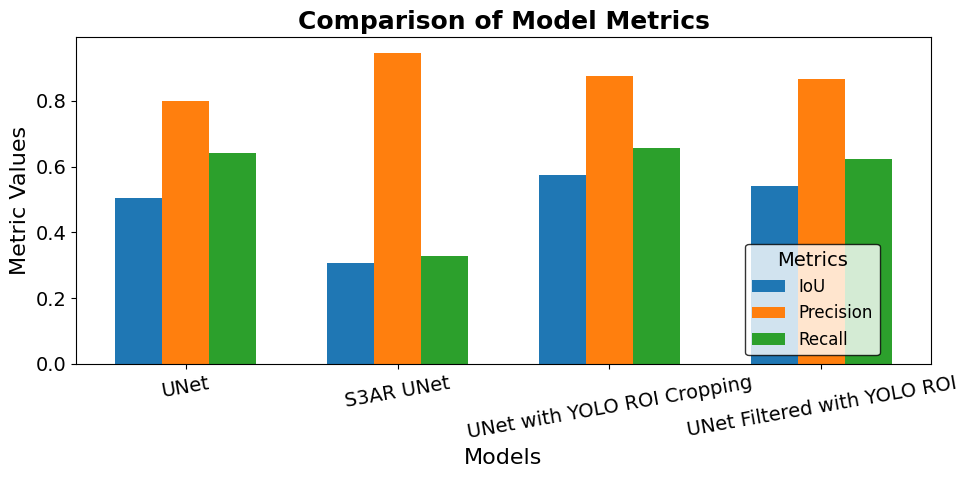

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison_graph(csv_files, model_names):
    metrics = ["IoU", "Precision", "Recall"]
    data = {}

    for csv_file, model_name in zip(csv_files, model_names):
        df = pd.read_csv(csv_file)
        overall_metrics = df[df["Patient"] == "Overall"].iloc[0]
        data[model_name] = {metric: overall_metrics[metric] for metric in metrics}

    metrics_df = pd.DataFrame(data).T

    x = np.arange(len(model_names))  # Posiciones de los modelos
    width = 0.2  # Ajusta el ancho de las barras

    # Agrandar la fuente de todo el gráfico
    plt.rcParams.update({'font.size': 14})  # Ajusta la fuente globalmente

    fig, ax = plt.subplots(figsize=(10, 5))

    # Ajustar la separación entre los modelos
    spacing_factor = 0.9
    x = x * spacing_factor  

    for i, metric in enumerate(metrics):
        ax.bar(x + i * width - width, metrics_df[metric], width, label=metric)

    # Ajustar tamaños de texto manualmente si es necesario
    ax.set_title("Comparison of Model Metrics", fontsize=18, fontweight='bold')  # Título más grande
    ax.set_xlabel("Models", fontsize=16)  # Etiqueta del eje X
    ax.set_ylabel("Metric Values", fontsize=16)  # Etiqueta del eje Y
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=10, fontsize=14)  # Tamaño de las etiquetas en el eje X

    # Leyenda con fuente más grande
    legend = plt.legend(title="Metrics", fontsize=12, loc='lower right', bbox_to_anchor=(0.95, 0), frameon=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor("black")  # Agregar borde negro

   
    plt.tight_layout()
    plt.show()

# Archivos CSV
csv_files = [
    "evaluation_unet_metrics.csv",
    "evaluation_s3ar_unet_metrics.csv",
    "evaluation_roi_yolo_unet_metrics.csv",
    "evaluation_filter_unet_yolo_metrics.csv",
]

# Nombres de los modelos
model_names = [
    "UNet",
    "S3AR UNet",
    "UNet with YOLO ROI Cropping",
    "UNet Filtered with YOLO ROI",
]

plot_comparison_graph(csv_files, model_names)


<Figure size 1000x400 with 0 Axes>

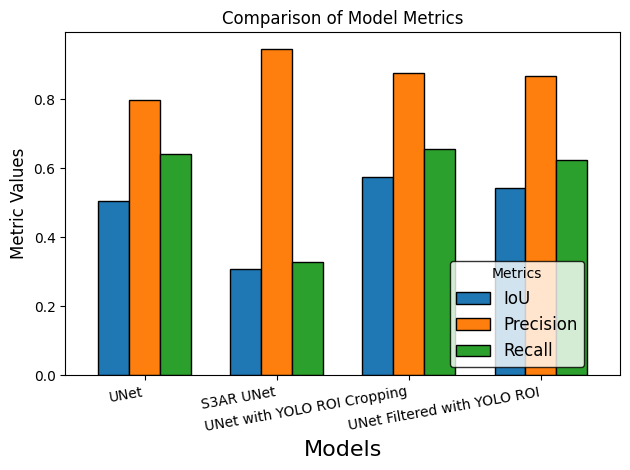

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_comparison_graph(csv_files, model_names):
    metrics = ["IoU", "Precision", "Recall"]
    data = {}

    for csv_file, model_name in zip(csv_files, model_names):
        df = pd.read_csv(csv_file)
        overall_metrics = df[df["Patient"] == "Overall"].iloc[0]
        data[model_name] = {metric: overall_metrics[metric] for metric in metrics}

    metrics_df = pd.DataFrame(data).T

    plt.figure(figsize=(16, 2))  # Hacer el gráfico más ancho
    ax = metrics_df.plot(kind="bar", width=0.7, edgecolor='black')

    # Mejoramos la alineación de los nombres de los modelos
    plt.xticks( rotation=10,ha='right')

    # Ajustamos el título y etiquetas
    plt.title("Comparison of Model Metrics", fontsize=12)
    plt.xlabel("Models", fontsize=16)
    plt.ylabel("Metric Values", fontsize=12)

    # Ubicar la leyenda en la esquina inferior derecha sin tapar barras
    legend = plt.legend(title="Metrics", fontsize=12, loc='lower right', bbox_to_anchor=(0.95, 0), frameon=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor("black")  # Agregar borde negro

   
    plt.subplots_adjust(bottom=0.3)  # Aumentar espacio en la parte inferior para evitar cortes

    plt.tight_layout()  # Ajustar diseño para evitar cortes

    # Guardar en alta calidad
    plt.savefig("figure.png", dpi=300, bbox_inches='tight')  
    plt.savefig("figure.svg", format="svg", bbox_inches='tight')  

    plt.show()

# Archivos CSV y nombres de modelos
csv_files = [
    "evaluation_unet_metrics.csv",
    "evaluation_s3ar_unet_metrics.csv",
    "evaluation_roi_yolo_unet_metrics.csv",
    "evaluation_filter_unet_yolo_metrics.csv",
]

model_names = [
    "UNet",
    "S3AR UNet",
    "UNet with YOLO ROI Cropping",
    "UNet Filtered with YOLO ROI",
]

plot_comparison_graph(csv_files, model_names)


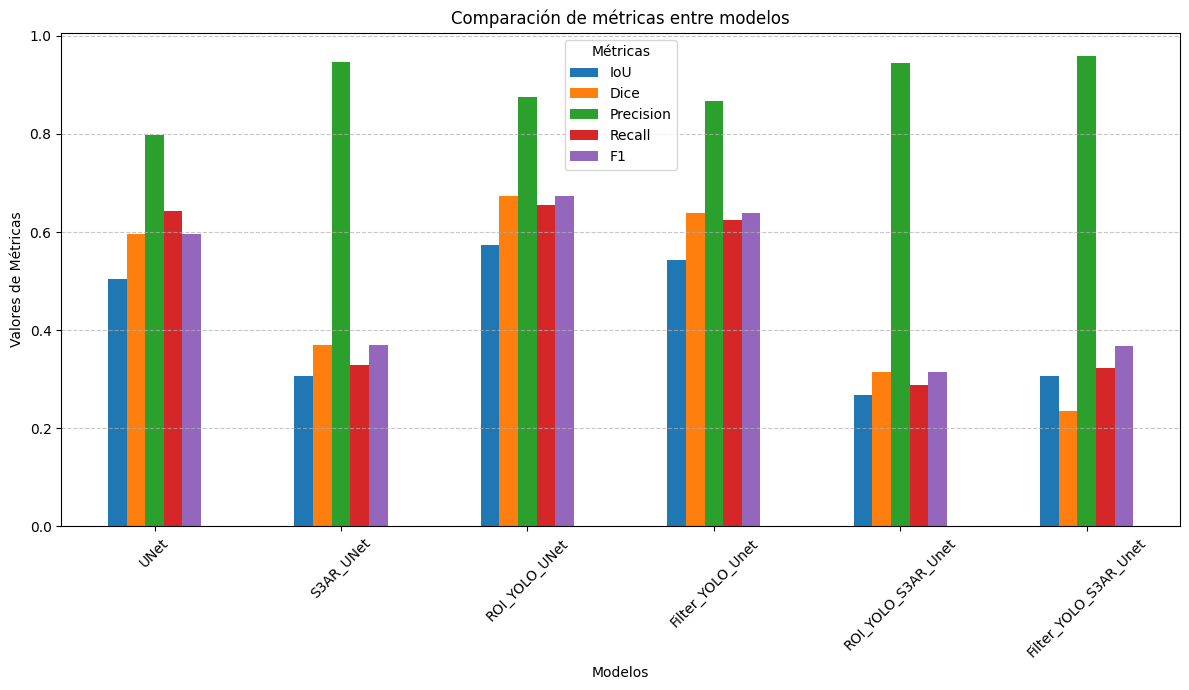

In [25]:
df = pd.read_csv("s3ar_unet_metrics_FILTER.csv")
df.columns = ["Patient"] + list(df.columns[1:])
df.to_csv("s3ar_unet_metrics_FILTER.csv_corrigido.csv", index=False)


<Figure size 1200x800 with 0 Axes>

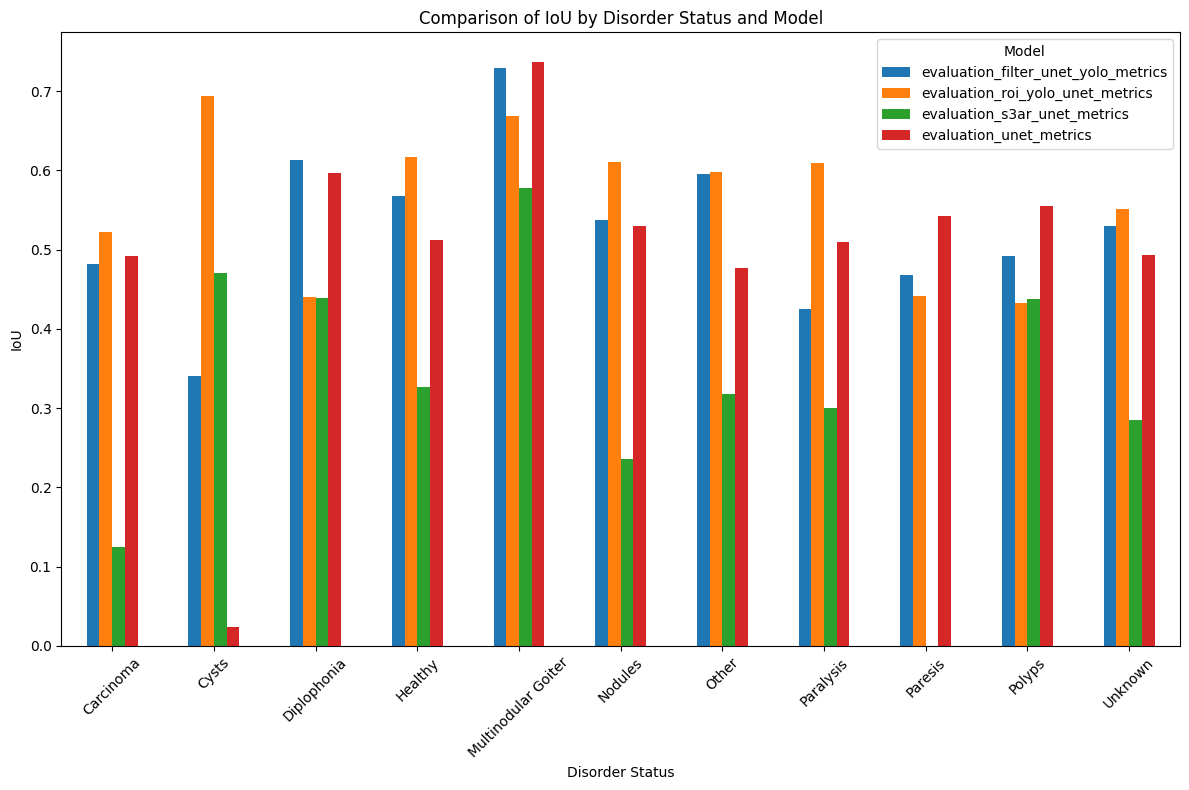

<Figure size 1200x800 with 0 Axes>

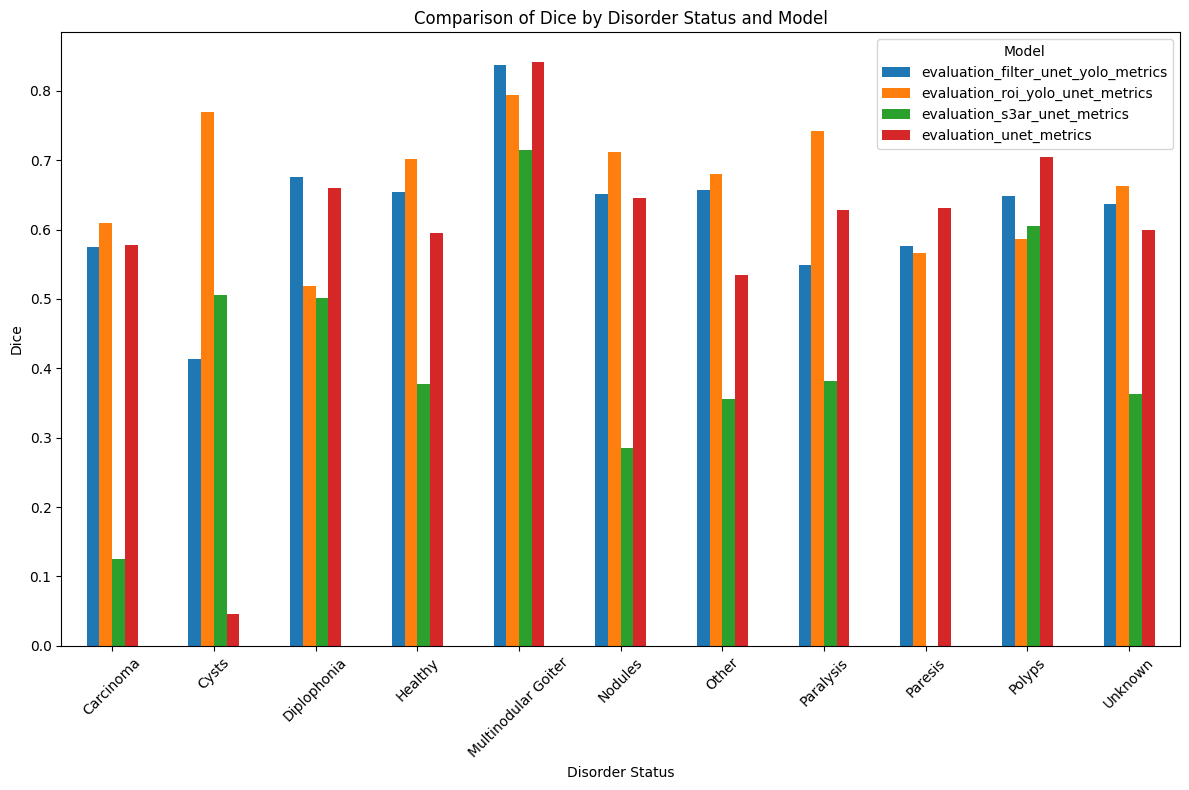

<Figure size 1200x800 with 0 Axes>

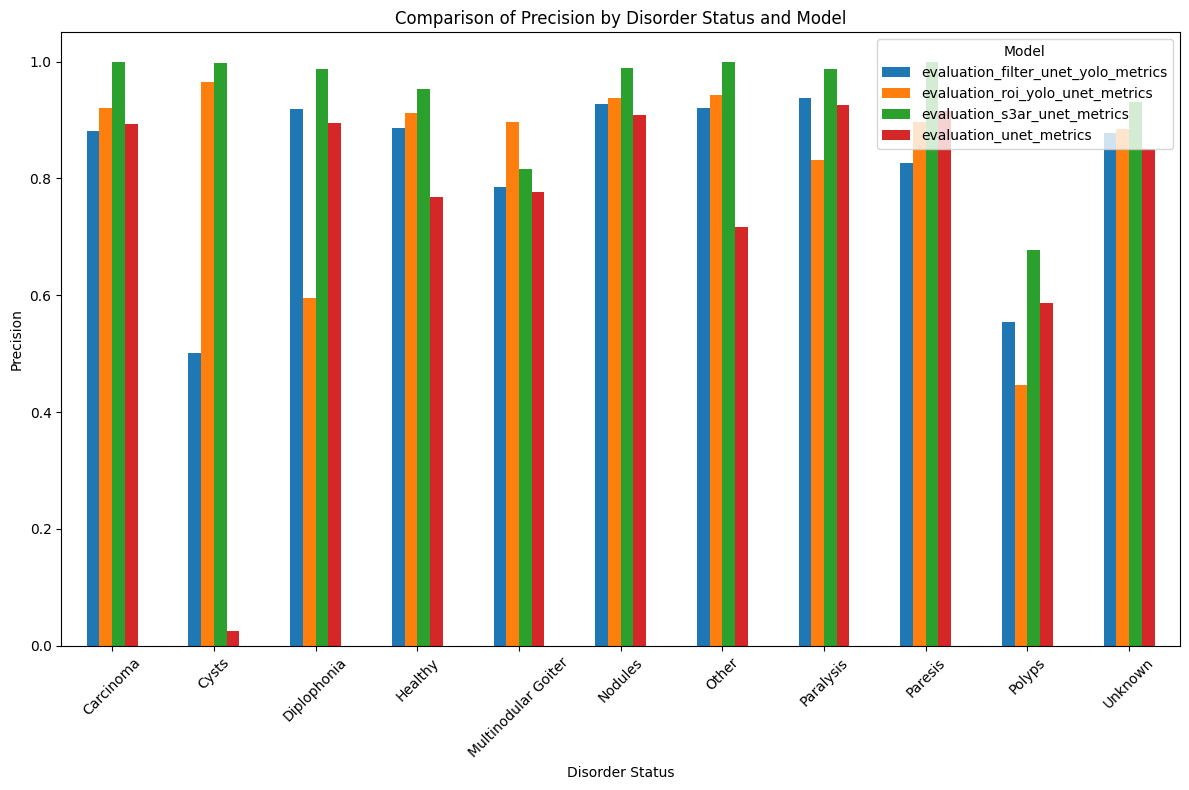

<Figure size 1200x800 with 0 Axes>

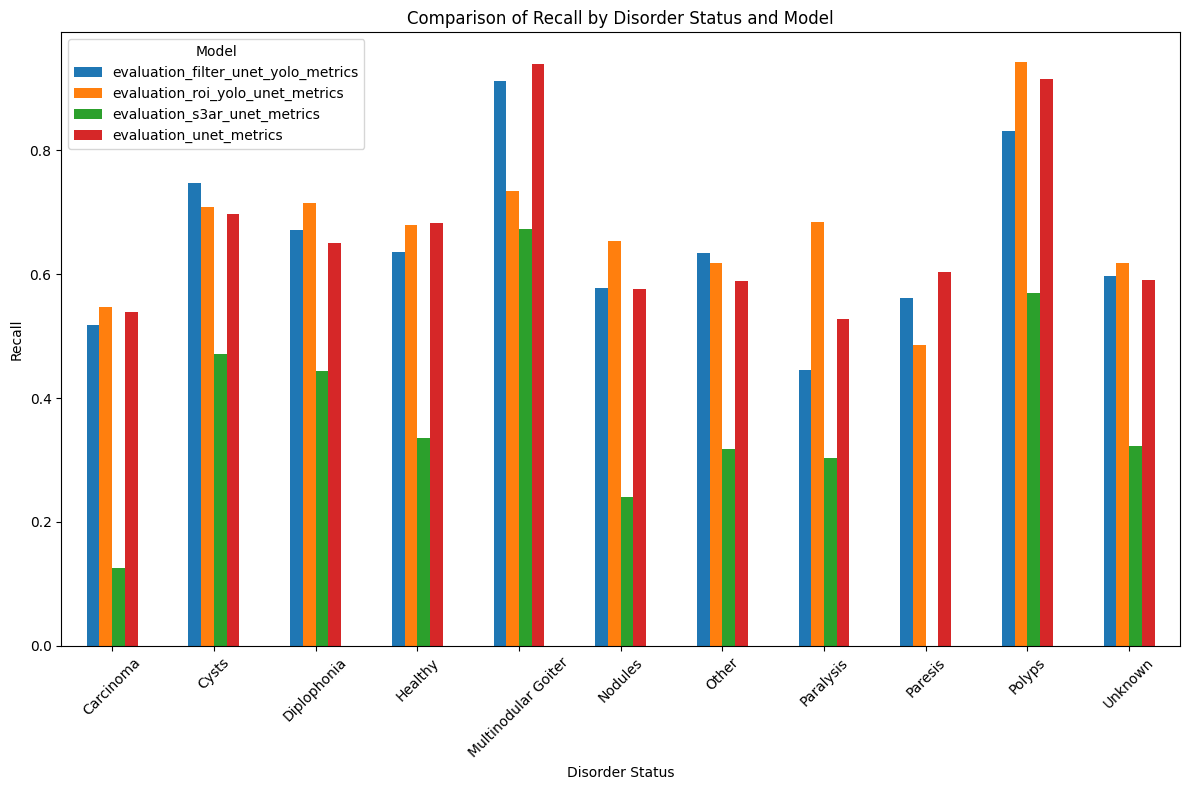

<Figure size 1200x800 with 0 Axes>

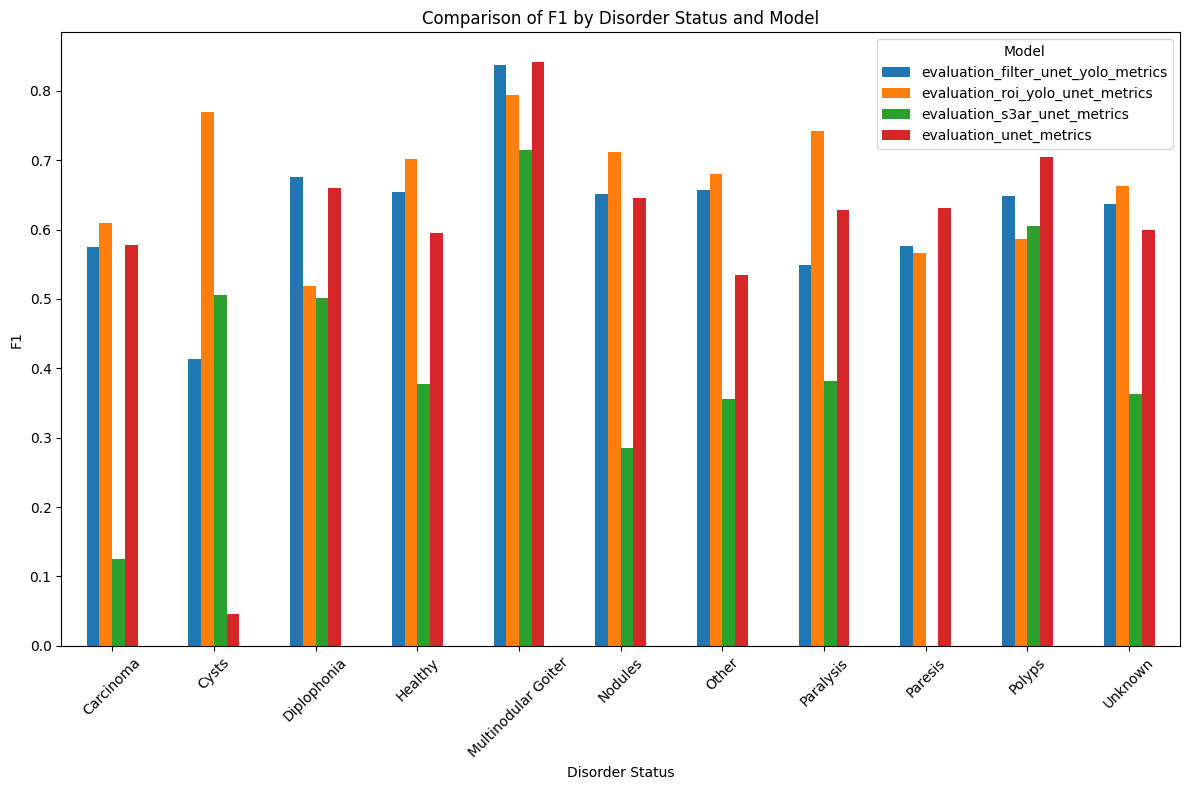

In [32]:
def load_disorder_status(base_path):
    """Carga el disorder status` de cada paciente desde los archivos JSON."""
    patient_status = {}
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        json_path = os.path.join(folder_path, "metadata.json")

        if os.path.exists(json_path):
            with open(json_path, "r") as f:
                data = json.load(f)
                disorder_status = data.get("disorder status", "Unknown")
                patient_status[folder] = disorder_status
        else:
            print(f"No se encontró archivo JSON para: {folder}")

    return patient_status


def merge_csv_with_disorder_status(csv_files, disorder_status, output_csv):
    """Combina las métricas de los CSV con la información de `disorder status`."""
    combined_data = []

    for csv_file in csv_files:
        model_name = os.path.splitext(os.path.basename(csv_file))[0] 
        df = pd.read_csv(csv_file)
        
        df["Disorder Status"] = df["Patient"].map(disorder_status).fillna("Unknown")
        df["Model"] = model_name

        combined_data.append(df)

    combined_df = pd.concat(combined_data, ignore_index=True)
    combined_df.to_csv(output_csv, index=False)
    return combined_df

def plot_metrics_by_disorder_status(combined_df):
    """Genera gráficas comparativas de métricas por `disorder status` y modelo."""
    metrics = ["IoU", "Dice", "Precision", "Recall", "F1"]

    for metric in metrics:
        plt.figure(figsize=(12, 8))
        grouped = combined_df.groupby(["Disorder Status", "Model"])[metric].mean().unstack()
        grouped.plot(kind="bar", figsize=(12, 8))
        plt.title(f"Comparison of {metric} by Disorder Status and Model")
        plt.xlabel("Disorder Status")
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.legend(title="Model")
        plt.tight_layout()
        plt.show()

base_path = "/home/voicelab/Desktop/segmentation_glottis/datasets/GIRAFE/Raw_Data"
csv_files = [
    "evaluation_unet_metrics.csv",
    "evaluation_s3ar_unet_metrics.csv",
    "evaluation_roi_yolo_unet_metrics.csv",
    "evaluation_filter_unet_yolo_metrics.csv",
]
output_csv = "/home/voicelab/Desktop/segmentation_glottis/datasets/combined_metrics_by_disorder2.csv"

disorder_status = load_disorder_status(base_path)

combined_df = merge_csv_with_disorder_status(csv_files, disorder_status, output_csv)


plot_metrics_by_disorder_status(combined_df)


<Figure size 1400x800 with 0 Axes>

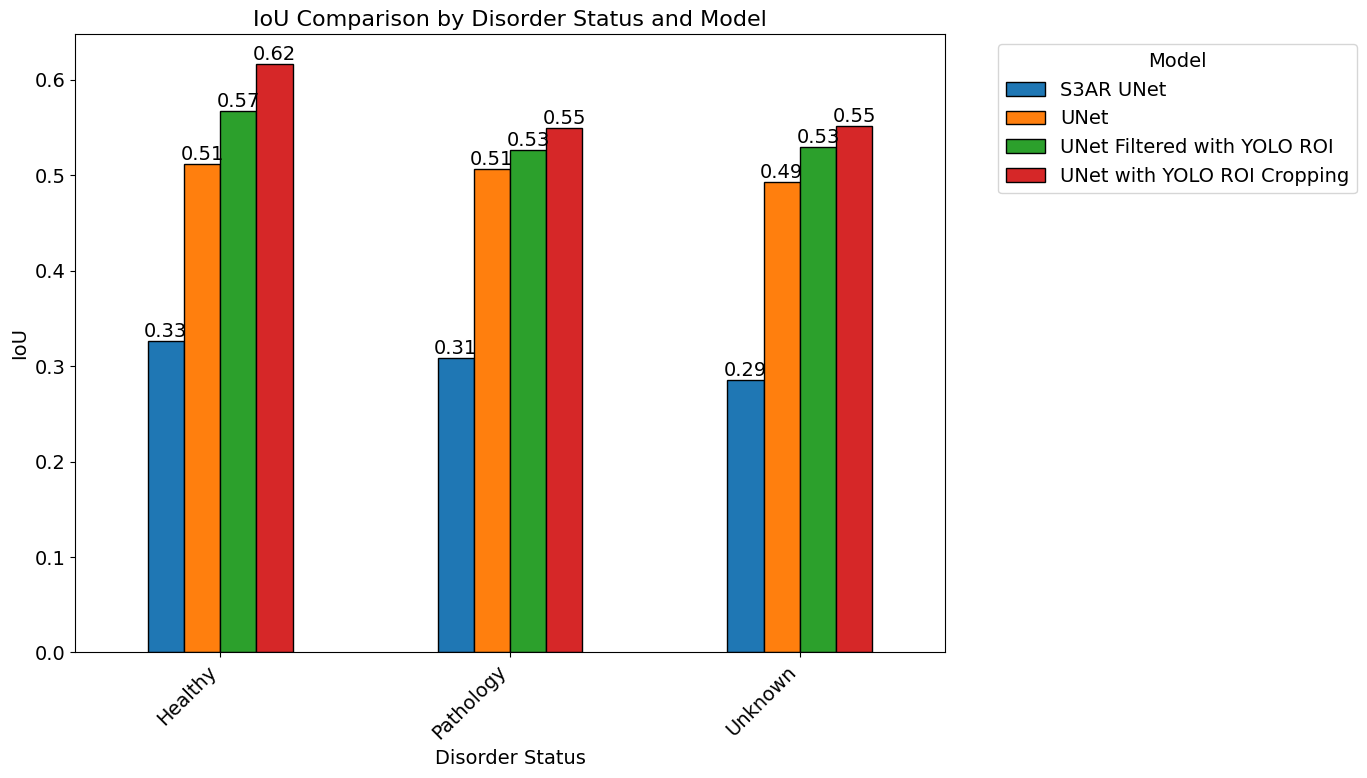

In [25]:
import os
import csv
import json
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_iou(mask1, mask2):
    """
    Calculates the Intersection over Union (IoU) between two masks.
    
    Parameters:
        mask1 (numpy.ndarray): Ground truth mask.
        mask2 (numpy.ndarray): Predicted mask.
    
    Returns:
        float: IoU score.
    """
    if np.sum(mask1) == 0 and np.sum(mask2) == 0:
        return 1.0
    elif np.sum(mask1) == 0 or np.sum(mask2) == 0:
        return 0.0
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def save_metrics_to_csv(output_csv, results, overall_metrics):
    """
    Saves the evaluation metrics to a CSV file.
    
    Parameters:
        output_csv (str): Path to the output CSV file.
        results (dict): Metrics for each patient.
        overall_metrics (dict): Overall metrics.
    """
    with open(output_csv, "w", newline="") as csvfile:
        fieldnames = ["Patient", "IoU", "Precision", "Recall"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for patient, metrics in results.items():
            row = {"Patient": patient, **metrics}
            writer.writerow(row)

        writer.writerow({"Patient": "Overall", **overall_metrics})

def evaluate_new_unet(base_path, unet_model):
    """
    Evaluates the UNet model on the dataset and calculates IoU, Precision, and Recall metrics.
    
    Parameters:
        base_path (str): Path to the dataset directory.
        unet_model (keras.Model): Trained UNet model.
    
    Returns:
        tuple: (metrics_by_patient, overall_metrics)
    """
    metrics_by_patient = {}
    all_iou_scores, all_precision_scores, all_recall_scores = [], [], []

    input_shape = unet_model.input_shape
    img_height, img_width = input_shape[1], input_shape[2]

    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)

        if not folder.startswith("patient") or not os.path.isdir(folder_path):
            continue

        original_video_path = os.path.join(folder_path, f"{folder}_original.avi")
        mask_images_dir = os.path.join(folder_path, "masks")

        if not os.path.exists(original_video_path) or not os.path.exists(mask_images_dir):
            continue

        ims = io.mimread(original_video_path, memtest=False)
        iou_scores, precision_scores, recall_scores = [], [], []

        for frame_count, img_orig in enumerate(ims):
            mask_image_path = os.path.join(mask_images_dir, f"{folder}_mask_{frame_count:03d}.png")

            if not os.path.exists(mask_image_path):
                break

            frame_mask = cv2.imread(mask_image_path, cv2.IMREAD_GRAYSCALE)
            ground_truth_mask = (frame_mask > 0).astype(np.uint8)

            img = cv2.resize(img_orig, (img_width, img_height))
            img = img / 255.0
            img = img[np.newaxis, ...]

            seg_pred = unet_model.predict(img, verbose=0)
            mask = np.squeeze(seg_pred)

            if mask.ndim == 3 and mask.shape[2] > 1:
                mask = mask[..., 0]

            predicted_mask = np.round(mask).astype(np.uint8)
            resized_ground_truth = cv2.resize(ground_truth_mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)

            iou = calculate_iou(resized_ground_truth, predicted_mask)
            precision = precision_score(resized_ground_truth.flatten(), predicted_mask.flatten(), zero_division=1)
            recall = recall_score(resized_ground_truth.flatten(), predicted_mask.flatten(), zero_division=1)

            iou_scores.append(iou)
            precision_scores.append(precision)
            recall_scores.append(recall)

        metrics_by_patient[folder] = {
            "IoU": np.mean(iou_scores) if iou_scores else 0,
            "Precision": np.mean(precision_scores) if precision_scores else 0,
            "Recall": np.mean(recall_scores) if recall_scores else 0,
        }

        all_iou_scores.extend(iou_scores)
        all_precision_scores.extend(precision_scores)
        all_recall_scores.extend(recall_scores)

    overall_metrics = {
        "IoU": np.mean(all_iou_scores) if all_iou_scores else 0,
        "Precision": np.mean(all_precision_scores) if all_precision_scores else 0,
        "Recall": np.mean(all_recall_scores) if all_recall_scores else 0,
    }

    return metrics_by_patient, overall_metrics

def load_disorder_status(base_path):
    """
    Loads and categorizes the disorder status of each patient from JSON files.
    
    Parameters:
        base_path (str): Path to the dataset directory.
    
    Returns:
        dict: Mapping of patient folders to their disorder status.
    """
    patient_status = {}
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        json_path = os.path.join(folder_path, "metadata.json")

        if os.path.exists(json_path):
            with open(json_path, "r") as f:
                data = json.load(f)
                disorder = data.get("disorder status", "Unknown")
                if disorder.lower() == "healthy":
                    status = "Healthy"
                elif disorder.lower() == "unknown":
                    status = "Unknown"
                else:
                    status = "Pathology"
                patient_status[folder] = status
        else:
            print(f"JSON file not found for: {folder}")
            patient_status[folder] = "Unknown"

    return patient_status

def merge_csv_with_disorder_status(csv_files, model_names, disorder_status, output_csv):
    """
    Combines the metrics from CSV files with disorder status information and assigns custom model names.
    
    Parameters:
        csv_files (list): List of CSV file paths containing metrics.
        model_names (list): List of custom model names corresponding to the CSV files.
        disorder_status (dict): Mapping of patient folders to their disorder status.
        output_csv (str): Path to the output combined CSV file.
    
    Returns:
        pandas.DataFrame: Combined DataFrame containing metrics and disorder status.
    """
    combined_data = []

    # Ensure both lists have the same length
    if len(csv_files) != len(model_names):
        raise ValueError("The 'csv_files' and 'model_names' lists must have the same length.")

    # Iterate over both csv_files and model_names simultaneously
    for csv_file, model_name in zip(csv_files, model_names):
        df = pd.read_csv(csv_file)

        # Map disorder status
        df["Disorder Status"] = df["Patient"].map(disorder_status).fillna("Unknown")
        df["Model"] = model_name  # Assign custom model name

        combined_data.append(df)

    combined_df = pd.concat(combined_data, ignore_index=True)
    combined_df.to_csv(output_csv, index=False)
    return combined_df

def plot_iou_by_disorder_status(combined_df):
    """
    Generates a bar graph of the IoU metric by Disorder Status and Model.
    
    Parameters:
        combined_df (pandas.DataFrame): Combined DataFrame containing metrics and disorder status.
    """
    plt.figure(figsize=(14, 8))  # Increased figure width for better space

    # Group by Disorder Status and Model, then calculate the mean IoU
    grouped = combined_df.groupby(["Disorder Status", "Model"])["IoU"].mean().unstack()

    # Plotting
    ax = grouped.plot(kind="bar", figsize=(14, 8), edgecolor='black')

    # Set titles and labels with increased font sizes for better readability
    plt.title("IoU Comparison by Disorder Status and Model", fontsize=16)
    plt.xlabel("Disorder Status", fontsize=14)
    plt.ylabel("IoU", fontsize=14)

    # Rotate x-ticks for better readability
    plt.xticks(rotation=45, ha='right')

    # Adjust the legend to be outside the plot area on the right
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ensure layout is tight so nothing is cut off
    plt.tight_layout()

    # Add annotations with IoU values on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')

    # Display the plot
    plt.show()


# Define paths and filenames
base_path = "/home/voicelab/Desktop/segmentation_glottis/datasets/GIRAFE/Raw_Data"
csv_files = [
    "evaluation_unet_metrics.csv",
    "evaluation_s3ar_unet_metrics.csv",
    "evaluation_roi_yolo_unet_metrics.csv",
    "evaluation_filter_unet_yolo_metrics.csv",
]
model_names = [
    "UNet",
    "S3AR UNet",
    "UNet with YOLO ROI Cropping",
    "UNet Filtered with YOLO ROI",
]
output_csv = "/home/voicelab/Desktop/segmentation_glottis/datasets/combined_metrics_by_disorder2.csv"

# Load disorder status and merge with CSV metrics
disorder_status = load_disorder_status(base_path)
combined_df = merge_csv_with_disorder_status(csv_files, model_names, disorder_status, output_csv)

# Plot IoU by Disorder Status and Model
plot_iou_by_disorder_status(combined_df)


<Figure size 1400x800 with 0 Axes>

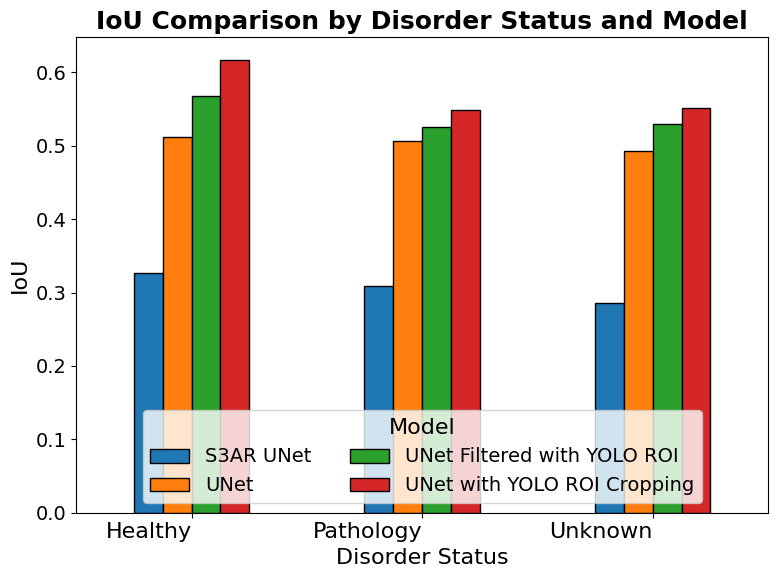

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_iou_by_disorder_status(combined_df):
    """
    Generates a bar graph of the IoU metric by Disorder Status and Model.
    
    Parameters:
        combined_df (pandas.DataFrame): Combined DataFrame containing metrics and disorder status.
    """
    plt.figure(figsize=(14, 8))  # Ampliar tamaño del gráfico

    # Agrupar por Disorder Status y Modelo, y calcular el IoU promedio
    grouped = combined_df.groupby(["Disorder Status", "Model"])["IoU"].mean().unstack()

    # Graficar barras
    ax = grouped.plot(kind="bar", figsize=(8, 6), edgecolor='black')

    # Ajustes de diseño
    plt.title("IoU Comparison by Disorder Status and Model", fontsize=18, fontweight="bold")
    plt.xlabel("Disorder Status", fontsize=16)
    plt.ylabel("IoU", fontsize=16)

    # Rotar etiquetas del eje X
    plt.xticks(rotation=0, ha='right', fontsize=16)

    # Ajustar leyenda en la parte inferior
    ax.legend(title="Model", fontsize=14, title_fontsize=16, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=2)

    # Ajustar diseño para evitar cortes
    plt.tight_layout()

    # Mostrar gráfico
    plt.show()

# Llamar la función con el DataFrame combinado
plot_iou_by_disorder_status(combined_df)


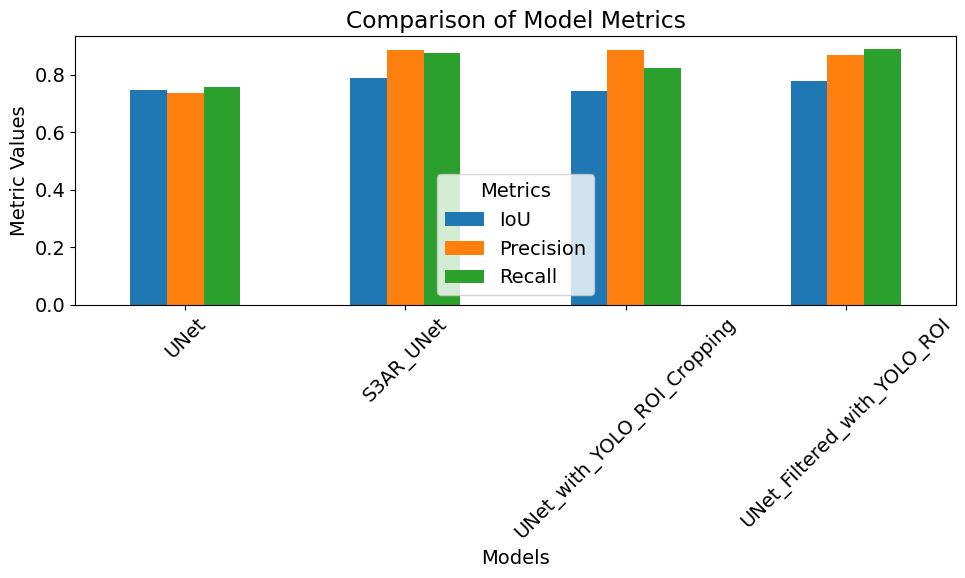

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_comparison_graph_custom():
    """
    Grafica la comparación de las métricas (IoU, Precision, Recall)
    para distintos modelos, con el mismo diseño que tu función original.
    """

    # 1. Definimos un diccionario con los valores de IoU, Precision, Recall
    #    en el mismo estilo que se usaría tras leerlos de un CSV.
    data = {
        "UNet": {
            "IoU": 0.7454,
            "Precision": 0.7367,
            "Recall": 0.7589
        },
        "S3AR_UNet": {
            "IoU": 0.7876,
            "Precision": 0.8870,
            "Recall": 0.8743
        },
        "UNet_with_YOLO_ROI_Cropping": {
            "IoU": 0.7437,
            "Precision": 0.8861,
            "Recall": 0.8230
        },
        "UNet_Filtered_with_YOLO_ROI": {
            "IoU": 0.7793,
            "Precision": 0.8680,
            "Recall": 0.8892
        }
    }

    # 2. Convertimos este diccionario en un DataFrame donde cada fila
    #    es un modelo, y cada columna es una métrica
    metrics_df = pd.DataFrame(data).T
    # Con .T (transpose) hacemos que queden:
    #  index = modelos
    #  columns = IoU, Precision, Recall

    # 3. Hacemos la gráfica de barras con el mismo formato
    metrics_df.plot(kind="bar", figsize=(10, 6))

    plt.title("Comparison of Model Metrics")
    plt.xlabel("Models")
    plt.ylabel("Metric Values")
    plt.xticks(rotation=45)
    plt.legend(title="Metrics")
    plt.tight_layout()
    plt.show()

plot_comparison_graph_custom()


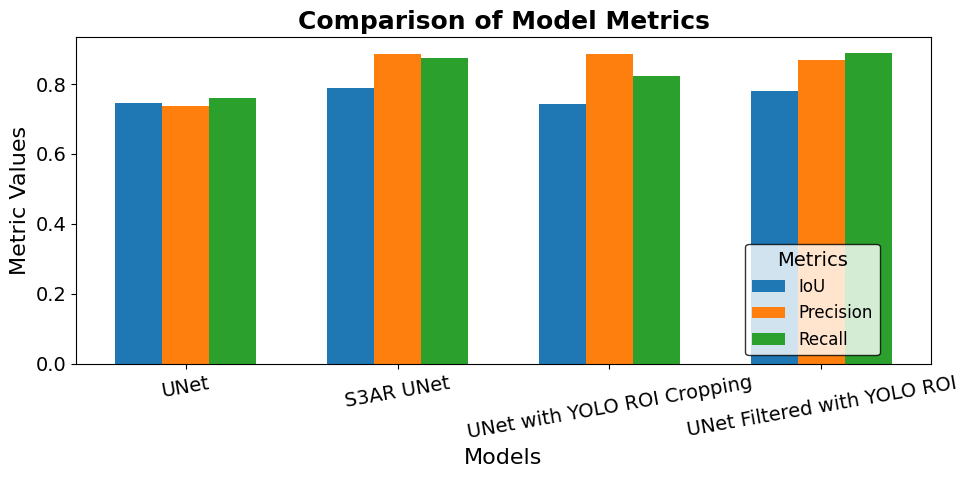

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison_graph_custom():
    """
    Grafica la comparación de las métricas (IoU, Precision, Recall)
    para distintos modelos, con el mismo diseño que la función original.
    """

    # 1. Definir datos en un diccionario
    data = {
        "UNet": {"IoU": 0.7454, "Precision": 0.7367, "Recall": 0.7589},
        "S3AR UNet": {"IoU": 0.7876, "Precision": 0.8870, "Recall": 0.8743},
        "UNet with YOLO ROI Cropping": {"IoU": 0.7437, "Precision": 0.8861, "Recall": 0.8230},
        "UNet Filtered with YOLO ROI": {"IoU": 0.7793, "Precision": 0.8680, "Recall": 0.8892}
    }

    # 2. Convertir datos en DataFrame
    metrics_df = pd.DataFrame(data).T  # Transpuesta para que modelos sean filas

    # 3. Configurar gráfico
    x = np.arange(len(metrics_df.index))  # Posiciones en el eje X
    width = 0.2  # Ancho de las barras
    spacing_factor = 0.9  # Ajuste de separación entre modelos
    x = x * spacing_factor  

    plt.rcParams.update({'font.size': 14})  # Fuente global más grande
    fig, ax = plt.subplots(figsize=(10, 5))

    # Graficar cada métrica como un grupo de barras
    for i, metric in enumerate(metrics_df.columns):
        ax.bar(x + i * width - width, metrics_df[metric], width, label=metric)

    # 4. Ajustes de diseño
    ax.set_title("Comparison of Model Metrics", fontsize=18, fontweight='bold')
    ax.set_xlabel("Models", fontsize=16)
    ax.set_ylabel("Metric Values", fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_df.index, rotation=10, fontsize=14)

    # Ajustar leyenda con fuente más grande
    ax.legend(title="Metrics", fontsize=14, title_fontsize=16, loc='upper right')

        # Leyenda con fuente más grande
    legend = plt.legend(title="Metrics", fontsize=12, loc='lower right', bbox_to_anchor=(0.95, 0), frameon=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor("black")  # Agregar borde negro

   
    plt.tight_layout()
    plt.show()

plot_comparison_graph_custom()
